Business Challenge: EDA and SQL


In [ ]:
import csv
import chardet

file_path = r"C:\Users\Dan\OneDrive - Gasco Industrial Corp\Global Health Statistics.csv"

# count numer of rows
with open(file_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    row_count = sum(1 for row in reader)

# show encoding
with open(file_path, 'rb') as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']

print(f"Total number of rows: {row_count}")
print(f"Detected Encoding: {encoding}")


In [ ]:
import csv
import chardet
import os
from typing import Dict


def split_csv_into_chunks(
    input_file: str,
    column_mapping: Dict[str, str]
) -> None:
    """
    Splits a CSV file into 10 chunks, renames the column headers
    according to a provided mapping, and saves each chunk as a separate file.

    :param input_file: The path to the input CSV file.
    :param column_mapping: A dictionary mapping original CSV column headers to new column names.

    Example:
        column_mapping = {
            "Country": "Country",
            "Year": "Year",
            ...
        }
        split_csv_into_chunks(
            input_file="C:/path/to/Global Health Statistics.csv",
            column_mapping=column_mapping
        )
    """

    # Fixed number of chunks
    num_chunks = 10

    # -------------------------------------------------------------------------
    # VALIDATION CHECKS
    # -------------------------------------------------------------------------
    # 1. Check if the input CSV file exists and is a file
    
    if not os.path.isfile(input_file):
        raise FileNotFoundError(f"Input file does not exist or is not a file: {input_file}")
    
    # 2. Check if file is non-empty (has at least 1 line)
    if os.path.getsize(input_file) == 0:
        raise ValueError(f"Input file is empty: {input_file}")

    # -------------------------------------------------------------------------
    # Create output folder for the chunks
    # -------------------------------------------------------------------------
    output_folder = os.path.join(os.path.dirname(input_file), "chunks")
    os.makedirs(output_folder, exist_ok=True)

    # -------------------------------------------------------------------------
    # EXCEPTION HANDLING for file operations
    # -------------------------------------------------------------------------
    try:
        # Detect file encoding
        with open(input_file, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            encoding = result['encoding'] if result['encoding'] else 'utf-8'
    except OSError as e:
        raise OSError(f"Failed to open/read the file for encoding detection: {e}")

    try:
        # Determine total number of rows (subtract 1 for the header row)
        with open(input_file, 'r', encoding=encoding) as infile:
            total_rows = sum(1 for _ in infile) - 1
    except OSError as e:
        raise OSError(f"Failed to open/read the file for row counting: {e}")

    # If there's no data besides the header, raise an error
    if total_rows <= 0:
        raise ValueError(f"Input file does not contain data rows only header: {input_file}")

    # Calculate rows per chunk
    rows_per_chunk = max(total_rows // num_chunks, 1)
    remainder = total_rows % num_chunks

    try:
        with open(input_file, 'r', encoding=encoding) as infile:
            reader = csv.reader(infile)
            original_header = next(reader)  # Extract the original header

            # Rename headers using the column_mapping
            renamed_header = [column_mapping.get(col, col) for col in original_header]

            chunk_number = 1
            rows_buffer = []

            for _, row in enumerate(reader, start=1):
                rows_buffer.append(row)
                rows_in_current_chunk = rows_per_chunk + (1 if remainder > 0 else 0)

                if len(rows_buffer) == rows_in_current_chunk:
                    _write_chunk(output_folder, chunk_number, renamed_header, rows_buffer)
                    chunk_number += 1
                    rows_buffer = []
                    if remainder > 0:
                        remainder -= 1

            # Write out any leftover rows
            if rows_buffer:
                _write_chunk(output_folder, chunk_number, renamed_header, rows_buffer)

        print(f"File successfully split into {chunk_number} chunk(s) in the folder: {output_folder}")

    except OSError as e:
        raise OSError(f"Error reading from input CSV file: {e}")


def _write_chunk(
    output_folder: str,
    chunk_number: int,
    header: list,
    rows: list
) -> None:
    """
    Helper function to write the specified rows to a chunked CSV file.

    :param output_folder: Directory where the chunked files will be saved.
    :param chunk_number: Current chunk index to be appended to the filename.
    :param header: Renamed header row.
    :param rows: List of rows (data) to be written.
    """
    output_file = os.path.join(output_folder, f"chunk_{chunk_number}.csv")
    try:
        with open(output_file, 'w', encoding='utf-8', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(header)
            writer.writerows(rows)
    except OSError as e:
        raise OSError(f"Unable to write chunk to file '{output_file}': {e}")

column_mapping = {
    "Country": "Country",
    "Year": "Year",
    "Disease Name": "DiseaseName",
    "Disease Category": "DiseaseCategory",
    "Prevalence Rate (%)": "PrevalenceRate",
    "Incidence Rate (%)": "IncidenceRate",
    "Mortality Rate (%)": "MortalityRate",
    "Age Group": "AgeGroup",
    "Gender": "Gender",
    "Population Affected": "PopulationAffected",
    "Healthcare Access (%)": "HealthcareAccess",
    "Doctors per 1000": "DoctorsPer1000",
    "Hospital Beds per 1000": "HospitalBedsPer1000",
    "Treatment Type": "TreatmentType",
    "Average Treatment Cost (USD)": "AverageTreatmentCost",
    "Availability of Vaccines/Treatment": "AvailabilityOfVaccinesTreatment",
    "Recovery Rate (%)": "RecoveryRate",
    "DALYs": "DALYs",
    "Improvement in 5 Years (%)": "ImprovementIn5Years",
    "Per Capita Income (USD)": "PerCapitaIncome",
    "Education Index": "EducationIndex",
    "Urbanization Rate (%)": "UrbanizationRate"
}

# path to CSV file
input_file_path = r"C:\Users\dbigman\OneDrive - SUDOC LLC\Desktop\Global Health Statistics.csv"

try:
    split_csv_into_chunks(
        input_file=input_file_path,
        column_mapping=column_mapping
    )
except Exception as e:
    print(f"An error occurred: {e}")

In [37]:
import pymysql
import pandas as pd
from icecream import ic

# Database connection settings
host = "localhost"  # host, e.g., 127.0.0.1 or a server address
user = "root"  # MySQL username
password = "Malcomx1"  # MySQL password
database = "GlobalHealth"  # database name

# Establish the connection
connection = pymysql.connect(
    host=host,
    user=user,
    password=password,
    database=database,
    local_infile=1  # Enable LOCAL INFILE
)

cursor = connection.cursor()

print(f"Connected to the {database} database successfully!")

# # TRUNCATE erases the tale. 
# try:
#     # Truncate the table
#     cursor.execute("TRUNCATE TABLE healthstatistics;")
#     connection.commit()
#     ic("Table healthstatistics has been cleared.")
# except pymysql.MySQLError as e:
#     ic(f"Error: {e}")
# finally:
#     # cursor.close()
#     # connection.close()

Connected to the GlobalHealth database successfully!


In [36]:
# Switch to SQLAlchemy, because of UserWarning: 
from sqlalchemy import create_engine

# Database connection settings
host = "localhost"  # host, e.g., 127.0.0.1 or a server address
user = "root"  #  MySQL username
password = "Malcomx1"  #  MySQL password
database = "GlobalHealth"  #  database name


# creates a SQLAlchemy engine, which serves as the entry point for interacting with the database
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

print(f"Connected to the {database} database successfully!")

Connected to the GlobalHealth database successfully!


In [ ]:
import os
import time

# Path to the folder containing the chunks
chunk_folder = r"C:\ProgramData\MySQL\MySQL Server 9.1\Uploads\chunks"

# Connect to MySQL

# Load each chunk file sequentially
for chunk_number in range(1, 11):  # Assuming chunks are named chunk_1.csv to chunk_10.csv
    chunk_file = os.path.join(chunk_folder, f"chunk_{chunk_number}.csv")
    print(f"Loading {chunk_file}...")
    
    # Construct the LOAD DATA INFILE query
    query = """
    LOAD DATA LOCAL INFILE '{chunk_file}'
    INTO TABLE healthstatistics
    FIELDS TERMINATED BY ',' 
    ENCLOSED BY '"'
    LINES TERMINATED BY '\\n'
    IGNORE 1 LINES
    (
        Country, Year, DiseaseName, DiseaseCategory, PrevalenceRate, IncidenceRate, MortalityRate, AgeGroup, Gender, PopulationAffected, 
        HealthcareAccess, DoctorsPer1000, HospitalBedsPer1000, TreatmentType, AverageTreatmentCost, AvailabilityOfVaccinesTreatment, RecoveryRate, DALYs,
        ImprovementIn5Years, PerCapitaIncome, EducationIndex, UrbanizationRate
    );
    """.format(chunk_file=chunk_file.replace("\\", "/"))
    
    try:
        # Start the timer
        start_time = time.time()    
        cursor.execute(query)
        connection.commit()
        # End the timer
        end_time = time.time()
        print(f"Successfully loaded {chunk_file}")
        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        # ic(f"Table healthstatistics has been cleared. Execution time: {elapsed_time:.2f} seconds")
        # print(f"Successfully loaded {chunk_file}")
        # Calculate and print the elapsed time

    except pymysql.MySQLError as e:
        print(f"Error loading {chunk_file}: {e}")

# Close the connection
# cursor.close()
# connection.close()
# print("All chunks loaded successfully.")


In [35]:
import numpy as np
from scipy import stats
import re


def descriptive_statistics(data, alpha=0.05):
    """
    Calculate various descriptive statistics for numerical continuous data.
    
    Parameters
    ----------
    data : array-like
        A 1D list or numpy array of numerical data (continuous).
    alpha : float, optional
        Significance level for confidence intervals (default is 0.05, i.e., 95% CI).

    Returns
    -------
    dict
        A dictionary containing:
            - 'count': Number of valid (non-NaN) data points
            - 'mean': Arithmetic mean
            - 'median': Median (Q2)
            - 'std': Standard Deviation
            - 'variance': Variance
            - 'range': Range (max - min)
            - 'min': Minimum value
            - 'max': Maximum value
            - 'mode': Mode (most frequent value)
            - 'iqr': Interquartile Range (Q3 - Q1)
            - 'quartiles': (Q1, Q2, Q3)
            - 'percentiles': Dictionary of selected percentiles (e.g. 5th, 95th)
            - 'mad': Median Absolute Deviation
            - 'skewness': Skewness
            - 'kurtosis': Kurtosis
            - 'cv': Coefficient of Variation (Std / Mean)
            - 'standard_error': Standard Error of the mean
            - 'confidence_interval': (lower_bound, upper_bound) for (1 - alpha)*100% CI
    """
    # Convert to a numpy array and remove any NaN/inf values
    data = np.array(data, dtype=float)
    data = data[np.isfinite(data)]
    
    # Edge case: if data is empty or has 1 element, handle gracefully
    if len(data) < 1:
        return {
            'count': 0,
            'mean': None,
            'median': None,
            'std': None,
            'variance': None,
            'range': None,
            'min': None,
            'max': None,
            'mode': None,
            'iqr': None,
            'quartiles': None,
            'percentiles': None,
            'mad': None,
            'skewness': None,
            'kurtosis': None,
            'cv': None,
            'standard_error': None,
            'confidence_interval': (None, None),
        }
    elif len(data) == 1:
        return {
            'count': 1,
            'mean': data[0],
            'median': data[0],
            'std': 0.0,
            'variance': 0.0,
            'range': 0.0,
            'min': data[0],
            'max': data[0],
            'mode': data[0],
            'iqr': 0.0,
            'quartiles': (data[0], data[0], data[0]),
            'percentiles': {'5th': data[0], '95th': data[0]},
            'mad': 0.0,
            'skewness': 0.0,
            'kurtosis': 0.0,
            'cv': 0.0,
            'standard_error': 0.0,
            'confidence_interval': (data[0], data[0]),
        }

    # Calculate the basic descriptive statistics
    n = len(data)
    count = n
    mean_ = np.mean(data)
    median_ = np.median(data)
    std_ = np.std(data, ddof=1)  # sample standard deviation (ddof=1)
    var_ = np.var(data, ddof=1)  # sample variance
    min_ = np.min(data)
    max_ = np.max(data)
    range_ = max_ - min_
    
    # Mode: can return multiple values; we'll pick the first.
    # SciPy >= 1.11 returns mode as an array; older versions return a single value.
    mode_res = stats.mode(data, keepdims=True)
    mode_ = mode_res.mode[0] if hasattr(mode_res, 'mode') else mode_res[0]

    # Interquartile range
    iqr_ = stats.iqr(data, interpolation='midpoint')
    
    # Quartiles (Q1, Q2, Q3)
    Q1, Q2, Q3 = np.percentile(data, [25, 50, 75])

    # Other percentiles (5th, 95th)
    p5, p95 = np.percentile(data, [5, 95])
    percentile_dict = {'5th': p5, '95th': p95}
    
    # Median Absolute Deviation (MAD)
    # SciPy 1.7+ has stats.median_abs_deviation.
    # If your version doesn't have it, you can compute manually:
    mad_ = stats.median_abs_deviation(data, scale='normal')

    # Skewness and Kurtosis
    skew_ = stats.skew(data, bias=False)
    kurt_ = stats.kurtosis(data, bias=False)

    # Coefficient of Variation (CV)
    # Guard against division by zero if mean_ is 0.
    cv_ = std_ / mean_ if mean_ != 0 else None

    # Standard Error of the Mean (SE)
    sem_ = std_ / np.sqrt(n)

    # Confidence Interval (we'll use t-distribution for smaller samples)
    # For large n, this approximates the normal distribution CI.
    # alpha = 0.05 => 95% CI
    t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
    ci_lower = mean_ - t_critical * sem_
    ci_upper = mean_ + t_critical * sem_
    
    stats_dict = {
        'count': count,
        'mean': mean_,
        'median': median_,
        'std': std_,
        'variance': var_,
        'range': range_,
        'min': min_,
        'max': max_,
        'mode': mode_,
        'iqr': iqr_,
        'quartiles': (Q1, Q2, Q3),
        'percentiles': percentile_dict,
        'mad': mad_,
        'skewness': skew_,
        'kurtosis': kurt_,
        'cv': cv_,
        'standard_error': sem_,
        'confidence_interval': (ci_lower, ci_upper),
    }
    
    return stats_dict



def is_numeric_mysql_type(mysql_type):
    """
    Returns True if mysql_type starts with 
    int, decimal, float, or double (case-insensitive)
    """
    return bool(re.match(r"^(int|decimal|float|double)", mysql_type.lower()))







In [33]:
try:

    # Get column names and data types dynamically
    cursor.execute("SHOW COLUMNS FROM HealthStatistics")
    columns = cursor.fetchall()

    # Filter numerical columns
    numerical_columns = [col[0] for col in columns if is_numeric_mysql_type(col[1])]

    # Build a query to fetch all numeric columns at once
    stats_query = f"SELECT {', '.join(numerical_columns)} FROM HealthStatistics"
    cursor.execute(stats_query)
    all_rows = cursor.fetchall()

    # Convert query results into a dictionary {col_name: [list_of_values]}
    data_dict = {col: [] for col in numerical_columns}
    for row in all_rows:
        for col, val in zip(numerical_columns, row):
            data_dict[col].append(val)

    # Calculate stats for each numeric column and store them in a dictionary
    # keyed by column name.
    all_stats = {}
    for col in numerical_columns:
        col_data = data_dict[col]
        stats_dict = descriptive_statistics(col_data, alpha=0.05)
        all_stats[col] = stats_dict

    # Convert 'all_stats' into a DataFrame
    # Rows = statistics (count, mean, median, etc.)
    # Columns = numeric column names
    df_stats = pd.DataFrame(all_stats)

    # rename the index for clarity
    df_stats.index.name = 'Statistic'

    print("Descriptive Statistics DataFrame:\n")
    print(df_stats)

    # Count distinct categorical values
    query_2 = """
    SELECT DiseaseCategory, COUNT(*) AS CountPerCategory
    FROM HealthStatistics
    GROUP BY DiseaseCategory;
    """
    cursor.execute(query_2)
    result_2 = cursor.fetchall()
    print("\nDistinct categorical values for DiseaseCategory:")
    for row in result_2:
        print(row)
        
      
    # Check null values in each column
            
    cursor.execute("SHOW COLUMNS FROM HealthStatistics")
    columns = cursor.fetchall()
    
    null_queries = []
    for column in columns:
        col_name = column[0]
        null_queries.append(f"SUM(CASE WHEN {col_name} IS NULL THEN 1 ELSE 0 END) AS NullCount_{col_name}")
    
    null_query = f"SELECT {', '.join(null_queries)} FROM HealthStatistics"
    cursor.execute(null_query)
    result_3 = cursor.fetchall()

    print("\nNull values per column:")
    for row in result_3:
        print(dict(zip([col[0] for col in columns], row)))        
        
finally:
    # Close the cursor and connection
    # cursor.close()
    # connection.close()
    print("Descriptive Statistics Done")

Descriptive Statistics DataFrame:

                                                         id  \
Statistic                                                     
count                                               1000002   
mean                                          639814.551443   
median                                             624279.5   
std                                           377575.482077   
variance                                142563244665.866272   
range                                             1279629.0   
min                                                     1.0   
max                                               1279630.0   
mode                                                    1.0   
iqr                                                655350.0   
quartiles                  (312139.25, 624279.5, 967489.75)   
percentiles           {'5th': 50001.05, '95th': 1229629.95}   
mad                                            485812.42325   
skewness            

In [34]:
# Question 1:
# Which infectious diseases have the highest prevalence rates globally, and how have these rates changed over the past 5 years?

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


query = """
SELECT
    DiseaseName,
    DiseaseCategory,
    Year,
    `PrevalenceRate`,
    `ImprovementIn5Years`
FROM
    HealthStatistics
WHERE
    DiseaseCategory = 'Infectious'
ORDER BY
    Year DESC;
"""

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql(query, connection)

# Close the database connection
# connection.close()

# Analyze the data
print("Data retrieved successfully!")

# Group data to find the highest average prevalence rates globally
highest_prevalence = (
    df.groupby("DiseaseName")
    .agg(
        Avg_Prevalence=("PrevalenceRate", "mean"),
        Total_Prevalence=("PrevalenceRate", "sum")
    )
    .sort_values(by="Avg_Prevalence", ascending=False)
)

# Analyze the change in prevalence rates over the last 5 years
recent_years = df[df['Year'] >= df['Year'].max() - 5]

prevalence_change = (
    recent_years.groupby("DiseaseName")
    .agg(
        Initial_Prevalence=("PrevalenceRate", lambda x: x.iloc[0]),
        Latest_Prevalence=("PrevalenceRate", lambda x: x.iloc[-1])
    )
    .assign(Change_in_Prevalence=lambda x: x["Latest_Prevalence"] - x["Initial_Prevalence"])
    .sort_values(by="Change_in_Prevalence", ascending=False)
)

# Merge both results
result = highest_prevalence.merge(prevalence_change, on="DiseaseName", how="inner")

# Display results
print("\nTop Infectious Diseases by Prevalence:")
print(highest_prevalence.head(10))

print("\nChange in Prevalence Rates Over the Last 5 Years:")
print(prevalence_change.head(10))


C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\2789501968.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


AttributeError: 'Connection' object has no attribute 'cursor'


Top Infectious Diseases by Prevalence:
             Avg_Prevalence  Total_Prevalence
DiseaseName                                  
Polio             10.353267           9887.37
Cholera           10.181133           9163.02
Malaria           10.179411           8988.42
Influenza         10.162589           9735.76
Diabetes          10.104290           9679.91
Dengue            10.081632           9325.51
Zika              10.076147           9048.38
Measles           10.069806           9334.71
COVID-19          10.032143           9410.15
Leprosy            9.997762           8888.01

Change in Prevalence Rates Over the Last 5 Years:
              Initial_Prevalence  Latest_Prevalence  Change_in_Prevalence
DiseaseName                                                              
Leprosy                     0.48              11.63                 11.15
Measles                    11.20              19.72                  8.52
Ebola                       7.06              15.11          

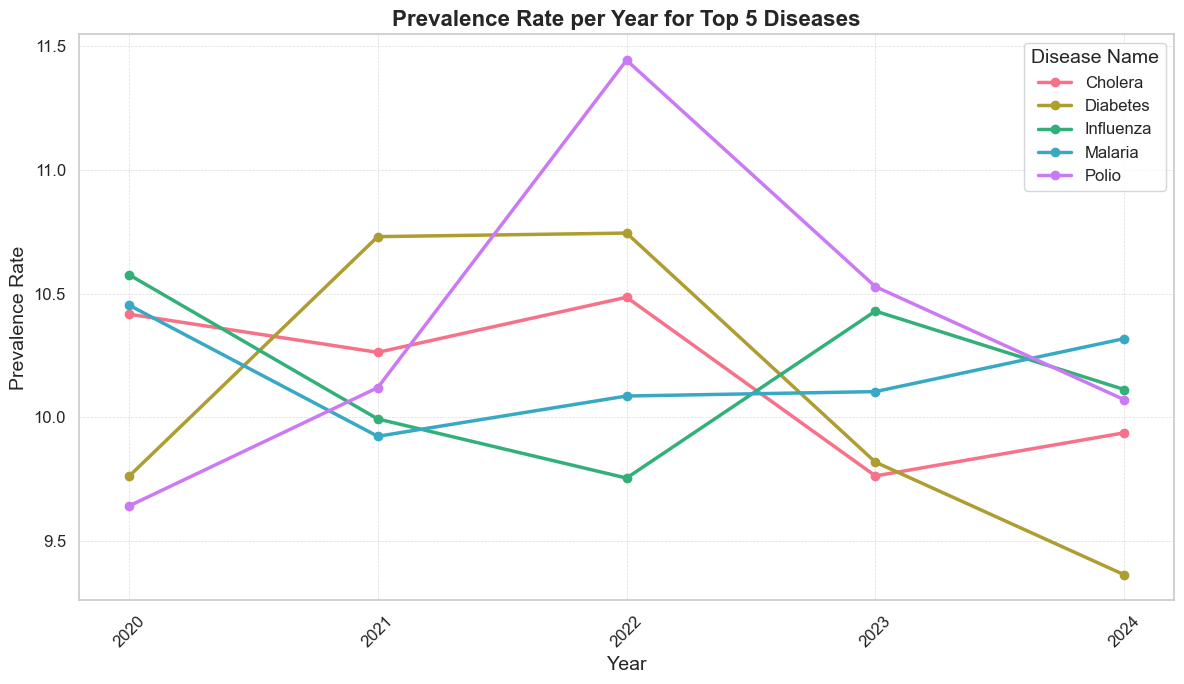

In [13]:
# Question 1:
# Which infectious diseases have the highest prevalence rates globally, and how have these rates changed over the past 5 years?

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SQL query to fetch data
query = """
SELECT
    DiseaseName,
    DiseaseCategory,
    Year,
    PrevalenceRate
FROM HealthStatistics
WHERE
    DiseaseCategory = 'Infectious'
    AND Year BETWEEN 2020 AND 2024
ORDER BY
    Year DESC;
"""

# Execute the query and load the data into a pandas DataFrame
df_question1 = pd.read_sql(query, engine)

# Analyze the data
# Step 1: Group data to find the highest average prevalence rates globally
highest_prevalence = (
    df_question1.groupby("DiseaseName")
    .agg(
        Avg_Prevalence=("PrevalenceRate", "mean"),
        Total_Prevalence=("PrevalenceRate", "sum")
    )
    .sort_values(by="Avg_Prevalence", ascending=False)
)

# Step 2: Analyze the change in prevalence rates over the last 5 years
recent_years = df_question1[df_question1['Year'] >= df_question1['Year'].max() - 5]

prevalence_change = (
    recent_years.groupby("DiseaseName")
    .agg(
        Initial_Prevalence=("PrevalenceRate", lambda x: x.iloc[0]),
        Latest_Prevalence=("PrevalenceRate", lambda x: x.iloc[-1])
    )
    .assign(Change_in_Prevalence=lambda x: x["Latest_Prevalence"] - x["Initial_Prevalence"])
    .sort_values(by="Change_in_Prevalence", ascending=False)
)

# Step 3: Merge both results
result = highest_prevalence.merge(prevalence_change, on="DiseaseName", how="inner")

# Display results
print("\nTop Infectious Diseases by Prevalence:")
print(highest_prevalence.head(10))

print("\nChange in Prevalence Rates Over the Last 5 Years:")
print(prevalence_change.head(10))

# Step 4: Sort data by year
df_question1_sorted = df_question1.sort_values(by='Year')

# Step 5: Select top 5 diseases by highest average prevalence rates
top_diseases = highest_prevalence.head(5).index

# Filter data for the top 5 diseases
top_diseases_data = df_question1_sorted[df_question1_sorted['DiseaseName'].isin(top_diseases)]

# Aggregate data by DiseaseName and Year
aggregated_data = (
    top_diseases_data.groupby(['DiseaseName', 'Year'])
    .agg({'PrevalenceRate': 'mean'})
    .reset_index()
)

# Plot the aggregated data
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))
palette = sns.color_palette("husl", len(top_diseases))  # colorful theme

for i, (disease, group) in enumerate(aggregated_data.groupby('DiseaseName')):
    plt.plot(group['Year'], group['PrevalenceRate'], 
             marker='o', label=disease, color=palette[i], linewidth=2.5)

# Add labels and title
plt.title('Prevalence Rate per Year for Top 5 Diseases', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Prevalence Rate', fontsize=14)
plt.xticks(sorted(aggregated_data['Year'].unique()), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title="Disease Name", fontsize=12, title_fontsize=14)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\2700701903.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection, params=params)


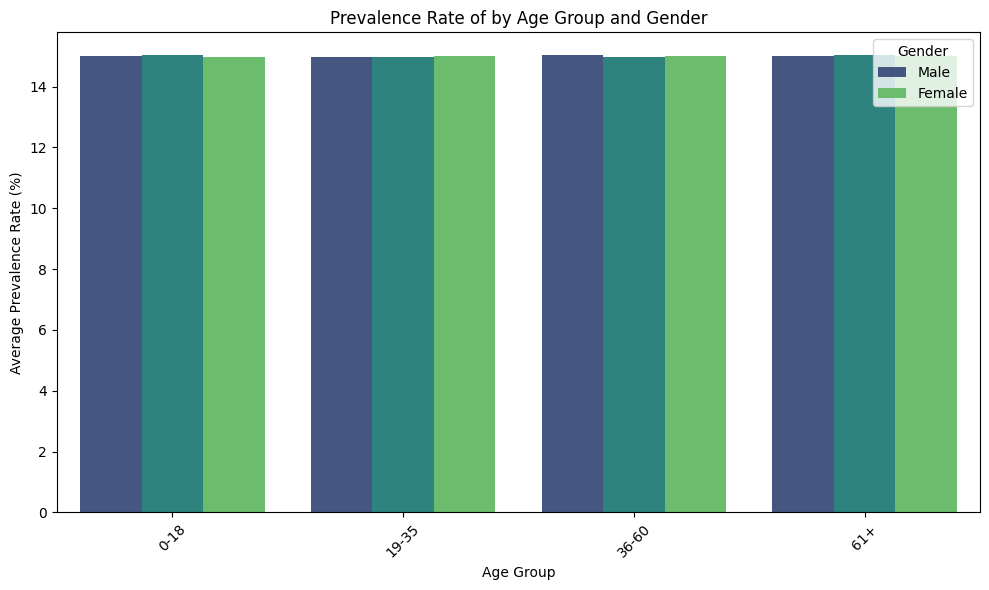

In [38]:
# Question 2:
# Which age groups and genders are most affected by high-prevalence infectious diseases? 
# Are there significant disparities?

def get_high_prevalence_data(connection: pymysql.connections.Connection, diseasecategory: str) -> pd.DataFrame:
    """    
    This function queries the `HealthStatistics` table to compute the average prevalence rate and 
    the total affected population for each combination of age group and gender within the specified 
    disease category. It filters the data to include only those entries where the prevalence rate 
    is greater than the average prevalence rate.

    Args:
        connection (pymysql.connections.Connection): A valid database connection created with PyMySQL.
        diseasecategory (str): The disease category to filter on (e.g., 'Infectious').

    Returns:
        pd.DataFrame: A pandas DataFrame containing columns:
                      - `AgeGroup`: The age group.
                      - `Gender`: The gender (Male, Female, Other).
                      - `AvgPrevalence`: The average prevalence rate for the group.
                      - `TotalAffected`: The total population affected for the group.
    """
        
    
    query = """
    SELECT
        AgeGroup,
        Gender,
        AVG(PrevalenceRate) AS AvgPrevalence,
        SUM(PopulationAffected) AS TotalAffected
    FROM HealthStatistics
    WHERE
        DiseaseCategory = %s
        AND PrevalenceRate > (
            SELECT AVG(PrevalenceRate)
            FROM HealthStatistics
            WHERE DiseaseCategory = %s
        )
    GROUP BY AgeGroup, Gender
    ORDER BY AvgPrevalence DESC;
    """
    params = (diseasecategory, diseasecategory)
    return pd.read_sql(query, connection, params=params)

# Call the function
df_question2 = get_high_prevalence_data(connection, 'Infectious')

# df_question2 = pd.read_sql(query_2, connection)

age_order = ['0-18', '19-35', '36-60', '61+']

df_question2['AgeGroup'] = pd.Categorical(df_question2['AgeGroup'], categories=age_order, ordered=True)

# Plot the graph with the updated order
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_question2,
    x="AgeGroup",
    y="AvgPrevalence",
    hue="Gender",
    palette="viridis"
)
plt.title("Prevalence Rate of by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Average Prevalence Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\1639260823.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_question3 = pd.read_sql(query_3, connection)


           DiseaseName  AvgHealthcareAccess  AvgDoctorsPer1000  \
0                 None                  NaN                NaN   
1  Alzheimer's Disease            74.941119           2.747002   
2               Asthma            75.000866           2.746590   
3               Cancer            75.012566           2.744735   
4              Cholera            74.963712           2.742675   

   AvgRecoveryRate  
0              NaN  
1        74.538244  
2        74.452923  
3        74.446244  
4        74.562658  
                     AvgHealthcareAccess  AvgDoctorsPer1000  AvgRecoveryRate
AvgHealthcareAccess             1.000000          -0.254349        -0.419404
AvgDoctorsPer1000              -0.254349           1.000000        -0.192732
AvgRecoveryRate                -0.419404          -0.192732         1.000000


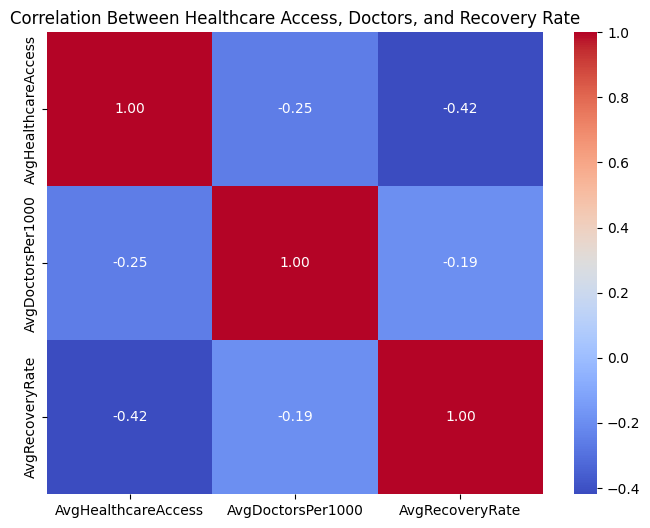

c:\Users\dbigman\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


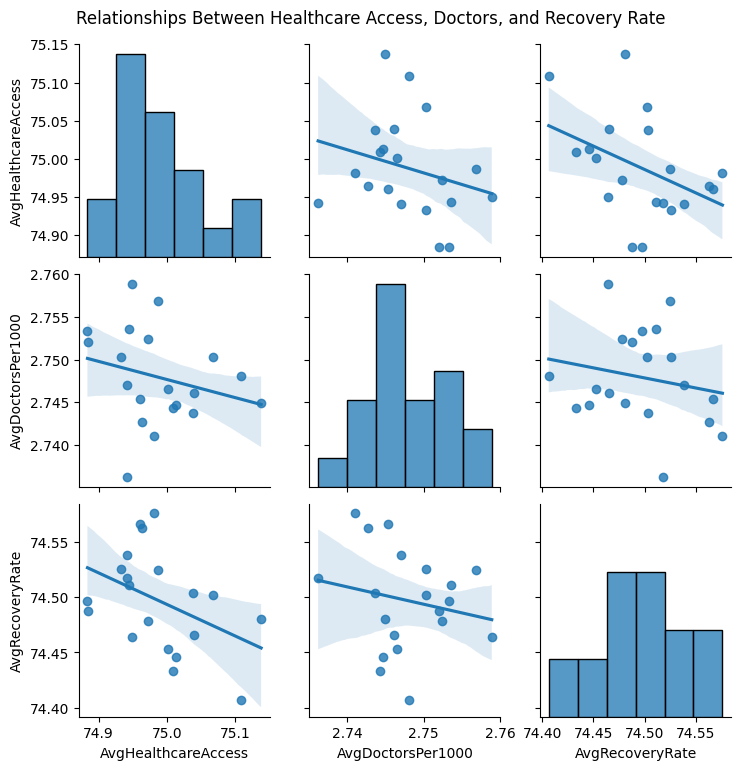

In [39]:
# Question 3: 
# Is there a correlation between healthcare access, the number of doctors per 1000 people, 
# and the recovery rate for specific diseases?

query_3 = """
SELECT
    DiseaseName,
    AVG(HealthcareAccess) AS AvgHealthcareAccess,
    AVG(DoctorsPer1000) AS AvgDoctorsPer1000,
    AVG(RecoveryRate) AS AvgRecoveryRate
FROM HealthStatistics
GROUP BY DiseaseName;
"""

df_question3 = pd.read_sql(query_3, connection)
print(df_question3.head())

correlation_matrix = df_question3[[
    'AvgHealthcareAccess',
    'AvgDoctorsPer1000',
    'AvgRecoveryRate'
]].corr()

print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Healthcare Access, Doctors, and Recovery Rate")
plt.show()


sns.pairplot(
    df_question3,
    vars=['AvgHealthcareAccess', 'AvgDoctorsPer1000', 'AvgRecoveryRate'],
    kind="reg"
)
plt.suptitle("Relationships Between Healthcare Access, Doctors, and Recovery Rate", y=1.02)
plt.show()



C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\574403037.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_question4 = pd.read_sql(query_4, connection)


           DiseaseName  AvgMortalityRate  AvgPerCapitaIncome  \
0  Parkinson's Disease          5.069338        50150.041864   
1               Cancer          5.068933        50239.745789   
2               Rabies          5.063906        50376.520740   
3            Influenza          5.057569        50102.506160   
4                 Zika          5.056438        50385.598772   

   AvgEducationIndex  
0           0.649957  
1           0.650294  
2           0.649285  
3           0.650901  
4           0.649948  
                    AvgMortalityRate  AvgPerCapitaIncome  AvgEducationIndex
AvgMortalityRate            1.000000           -0.329285          -0.076750
AvgPerCapitaIncome         -0.329285            1.000000           0.082558
AvgEducationIndex          -0.076750            0.082558           1.000000


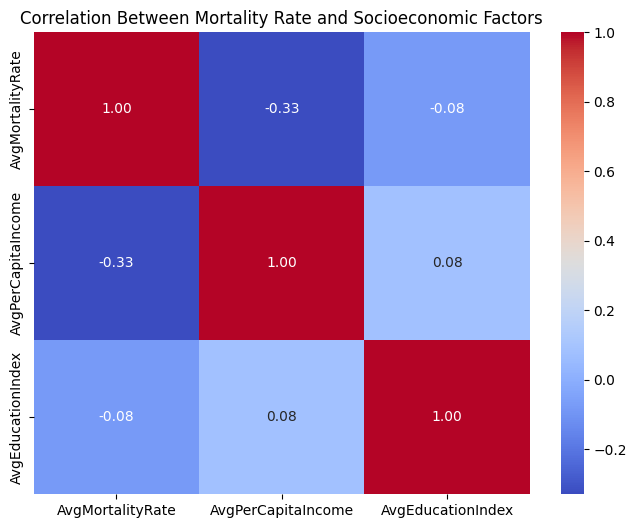

In [40]:
# Question 4: 
# Which infectious diseases have the highest mortality rates, and how do socioeconomic factors 
# (e.g., per capita income, education index) influence these rates?

query_4 = """
SELECT
    DiseaseName,
    AVG(MortalityRate) AS AvgMortalityRate,
    AVG(PerCapitaIncome) AS AvgPerCapitaIncome,
    AVG(EducationIndex) AS AvgEducationIndex
FROM HealthStatistics
GROUP BY DiseaseName
ORDER BY AvgMortalityRate DESC
LIMIT 10;
"""

df_question4 = pd.read_sql(query_4, connection)
print(df_question4.head())

# Calculate correlations
correlation_matrix = df_question4[[
    'AvgMortalityRate', 
    'AvgPerCapitaIncome', 
    'AvgEducationIndex'
]].corr()

print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Mortality Rate and Socioeconomic Factors")
plt.show()

C:\Users\dbigman\AppData\Local\Temp\ipykernel_10348\1616853608.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_urbanization = pd.read_sql(query, connection)


                     AvgUrbanizationRate  AvgIncidenceRate  AvgPrevalenceRate
AvgUrbanizationRate             1.000000         -0.142770           0.274668
AvgIncidenceRate               -0.142770          1.000000          -0.439319
AvgPrevalenceRate               0.274668         -0.439319           1.000000


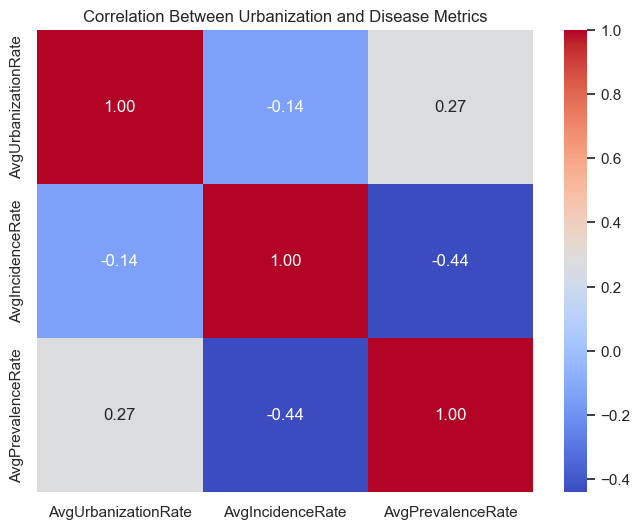

In [19]:
# Question 5:
# Does the urbanization rate affect the incidence and prevalence rates of infectious diseases? 
# Are urban areas more vulnerable to certain outbreaks?

query = """
SELECT
    DiseaseName,
    AVG(UrbanizationRate) AS AvgUrbanizationRate,
    AVG(IncidenceRate) AS AvgIncidenceRate,
    AVG(PrevalenceRate) AS AvgPrevalenceRate
FROM HealthStatistics
WHERE DiseaseCategory = 'Infectious'
GROUP BY DiseaseName
ORDER BY AvgUrbanizationRate DESC;
"""

# Execute the query and load the data into a pandas DataFrame
df_urbanization = pd.read_sql(query, connection)

df_urbanization.describe()
# Calculate correlation
correlation_matrix = df_urbanization[[
    'AvgUrbanizationRate',
    'AvgIncidenceRate',
    'AvgPrevalenceRate'
]].corr()

print(correlation_matrix)

# Visualize correlation as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Urbanization and Disease Metrics")
plt.show()



C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\951363643.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_treatment_cost = pd.read_sql(query_treatment_cost, connection)


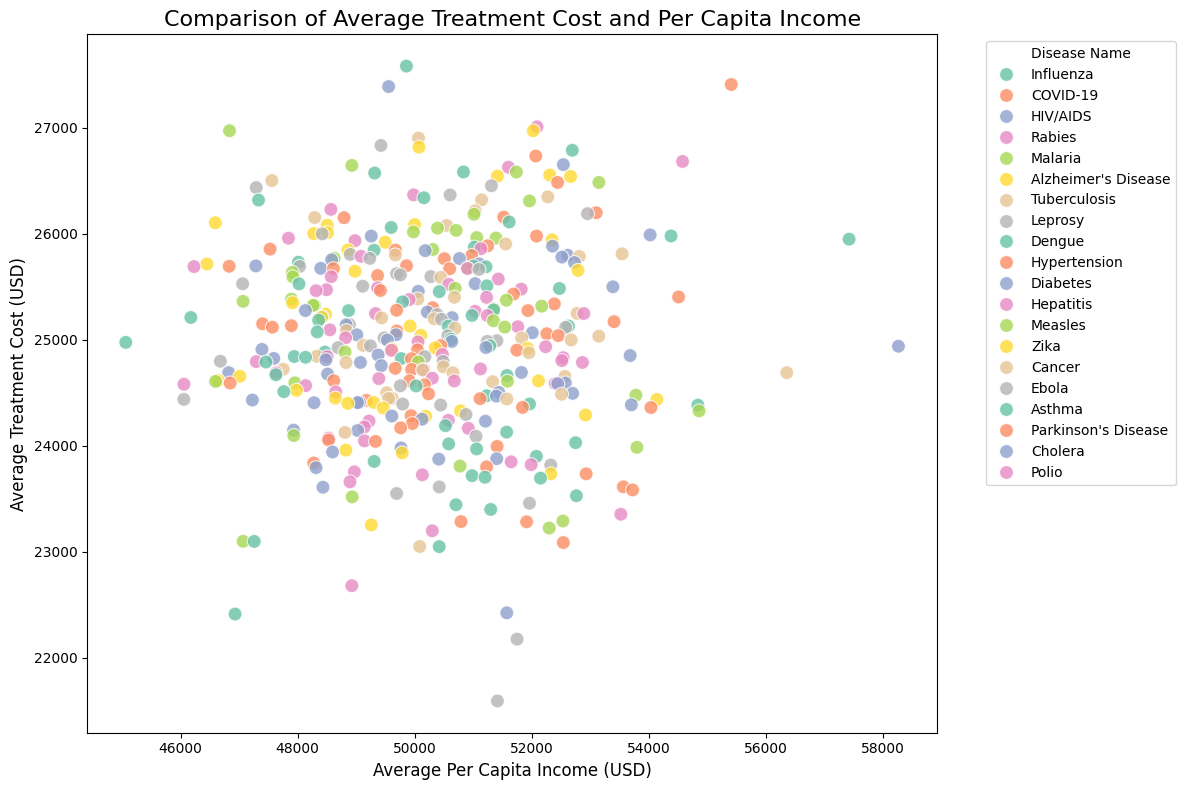

       AvgTreatmentCost  AvgPerCapitaIncome
count        400.000000          400.000000
mean       25017.133065        50288.256687
std          918.304499         1945.957610
min        21592.782222        45060.353909
25%        24446.419380        48867.130417
50%        25011.521691        50226.332353
75%        25673.356283        51572.830533
max        27581.779221        58271.036364


In [41]:
# 6.	Economic Burden:
# What is the average treatment cost (USD) for the most common infectious diseases, 
# and how does it compare to the per capita income in different countries?

import matplotlib.pyplot as plt
import seaborn as sns


# Define a query to calculate the average treatment cost for common infectious diseases
query_treatment_cost = """
SELECT
    DiseaseName,
    AVG(AverageTreatmentCost) AS AvgTreatmentCost,
    Country,
    AVG(PerCapitaIncome) AS AvgPerCapitaIncome
FROM HealthStatistics
WHERE DiseaseCategory = 'Infectious'
GROUP BY DiseaseName, Country
ORDER BY AvgTreatmentCost DESC;
"""

# Execute the query and load the data into a DataFrame
df_treatment_cost = pd.read_sql(query_treatment_cost, connection)

# Plot the comparison between treatment costs and per capita income
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_treatment_cost,
    x="AvgPerCapitaIncome",
    y="AvgTreatmentCost",
    hue="DiseaseName",
    palette="Set2",
    s=100,
    alpha=0.8
)

plt.title("Comparison of Average Treatment Cost and Per Capita Income", fontsize=16)
plt.xlabel("Average Per Capita Income (USD)", fontsize=12)
plt.ylabel("Average Treatment Cost (USD)", fontsize=12)
plt.legend(title="Disease Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Summary statistics
print(df_treatment_cost.describe())

C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\4268870804.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vaccine = pd.read_sql(query, connection)


           DiseaseName AvailabilityOfVaccinesTreatment  AvgMortalityRate  \
0             HIV/AIDS                             Yes          5.153536   
1               Dengue                              No          5.147725   
2  Parkinson's Disease                              No          5.124283   
3              Cholera                              No          5.119150   
4                 Zika                             Yes          5.106914   

   AvgRecoveryRate  
0        74.472044  
1        74.311980  
2        74.639644  
3        74.222884  
4        74.696067  
  AvailabilityOfVaccinesTreatment  AvgMortalityRate  AvgRecoveryRate
0                              No          5.047460        74.374314
1                             Yes          5.059264        74.503307


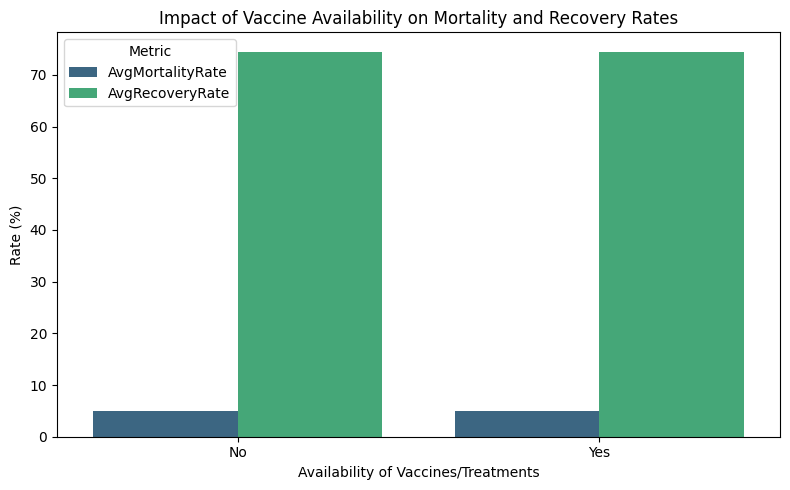

In [42]:
# How does the availability of vaccines or treatments impact the mortality and recovery rates for specific infectious diseases?


query = """
SELECT
    DiseaseName,
    AvailabilityOfVaccinesTreatment,
    AVG(MortalityRate) AS AvgMortalityRate,
    AVG(RecoveryRate) AS AvgRecoveryRate
FROM HealthStatistics
WHERE DiseaseCategory = 'Infectious'
GROUP BY DiseaseName, AvailabilityOfVaccinesTreatment
ORDER BY AvgMortalityRate DESC;
"""

df_vaccine = pd.read_sql(query, connection)
print(df_vaccine.head())

df_summary = df_vaccine.groupby("AvailabilityOfVaccinesTreatment").agg({
    "AvgMortalityRate": "mean",
    "AvgRecoveryRate": "mean"
}).reset_index()

print(df_summary)


# Bar plot for Mortality and Recovery Rates by Vaccine Availability
df_melted = df_summary.melt(id_vars="AvailabilityOfVaccinesTreatment", 
                            value_vars=["AvgMortalityRate", "AvgRecoveryRate"],
                            var_name="Metric", 
                            value_name="Rate")

plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x="AvailabilityOfVaccinesTreatment", y="Rate", hue="Metric", palette="viridis")
plt.title("Impact of Vaccine Availability on Mortality and Recovery Rates")
plt.xlabel("Availability of Vaccines/Treatments")
plt.ylabel("Rate (%)")
plt.tight_layout()
plt.show()



C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\639494033.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dalys = pd.read_sql(query, connection)


Top Diseases Contributing to DALYs:
    DiseaseName   TotalDALYs
0      COVID-19  126331645.0
1        Asthma  125850738.0
2       Leprosy  125449471.0
3        Dengue  125391463.0
4      HIV/AIDS  125366533.0
5       Cholera  125358861.0
6      Diabetes  125342789.0
7        Cancer  125275792.0
8          Zika  125185536.0
9  Tuberculosis  125169183.0


C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\639494033.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dalys, x="TotalDALYs", y="DiseaseName", palette="viridis")


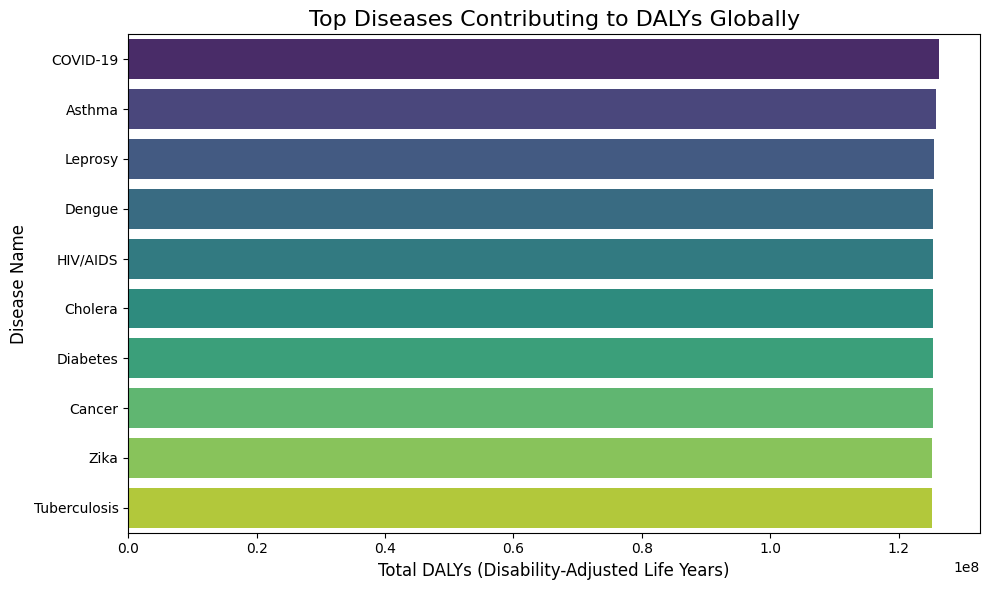

In [43]:
# Which diseases contribute the most to DALYs (Disability-Adjusted Life Years)?

# Define the query to fetch the top diseases contributing to DALYs
query = """
SELECT
    DiseaseName,
    SUM(DALYs) AS TotalDALYs
FROM HealthStatistics
GROUP BY DiseaseName
ORDER BY TotalDALYs DESC
LIMIT 10;
"""

# Execute the query and load the data into a DataFrame (ensure connection is set up)
df_dalys = pd.read_sql(query, connection)

# Display the top diseases contributing to DALYs
print("Top Diseases Contributing to DALYs:")
print(df_dalys)

# Create a bar plot for the top diseases by DALYs
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dalys, x="TotalDALYs", y="DiseaseName", palette="viridis")
plt.title("Top Diseases Contributing to DALYs Globally", fontsize=16)
plt.xlabel("Total DALYs (Disability-Adjusted Life Years)", fontsize=12)
plt.ylabel("Disease Name", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\1696327148.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_age_gender = pd.read_sql(query_age_gender_disparities, connection)


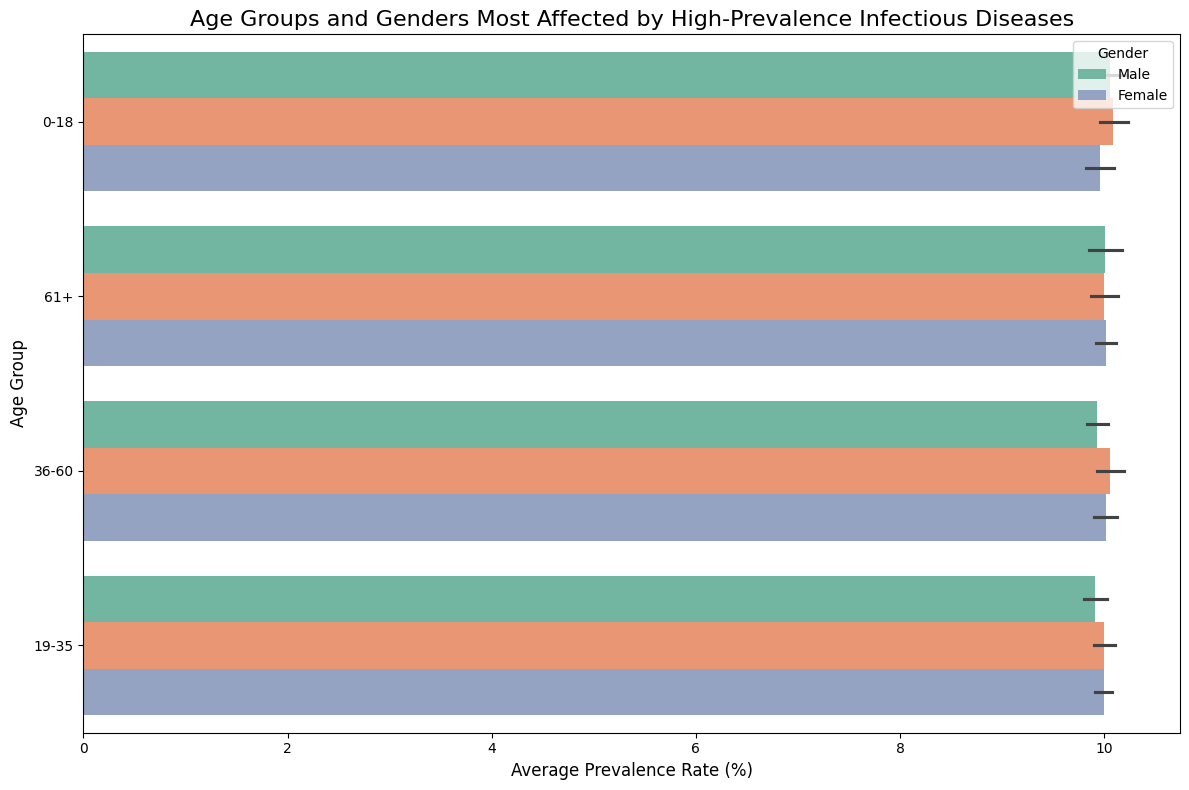

In [46]:
# 3.	Demographic Patterns:
# Which age groups and genders are most affected by high-prevalence infectious diseases?
# Are there significant disparities?

# Query to analyze the most affected age groups and genders for high-prevalence infectious diseases
query_age_gender_disparities = """
SELECT
    DiseaseName,
    AgeGroup,
    Gender,
    AVG(PrevalenceRate) AS AvgPrevalenceRate,
    MAX(PrevalenceRate) AS MaxPrevalenceRate
FROM HealthStatistics
WHERE DiseaseCategory = 'Infectious'
GROUP BY DiseaseName, AgeGroup, Gender
ORDER BY AvgPrevalenceRate DESC;
"""

# Execute the query and load the data into a DataFrame
df_age_gender = pd.read_sql(query_age_gender_disparities, connection)

# Display the top results
df_age_gender.head()

# Visualizing disparities by age group and gender
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_age_gender,
    x="AvgPrevalenceRate",
    y="AgeGroup",
    hue="Gender",
    palette="Set2"
)

plt.title("Age Groups and Genders Most Affected by High-Prevalence Infectious Diseases", fontsize=16)
plt.xlabel("Average Prevalence Rate (%)", fontsize=12)
plt.ylabel("Age Group", fontsize=12)
plt.legend(title="Gender", loc='upper right')
plt.tight_layout()
plt.show()




C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\3701994816.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_below_average = pd.read_sql(query_below_average, connection)


Countries with Healthcare Access and Hospital Beds Below Average:
+----+--------------+-----------------------+-------------------+
|    | Country      |   AvgHealthcareAccess |   AvgHospitalBeds |
+====+==============+=======================+===================+
|  0 | Australia    |               74.8807 |           5.22825 |
+----+--------------+-----------------------+-------------------+
|  1 | Canada       |               74.8993 |           5.23051 |
+----+--------------+-----------------------+-------------------+
|  2 | Turkey       |               74.9084 |           5.24398 |
+----+--------------+-----------------------+-------------------+
|  3 | Saudi Arabia |               74.9332 |           5.23775 |
+----+--------------+-----------------------+-------------------+
|  4 | Mexico       |               74.9382 |           5.24138 |
+----+--------------+-----------------------+-------------------+
|  5 | UK           |               74.9667 |           5.23533 |
+----+----

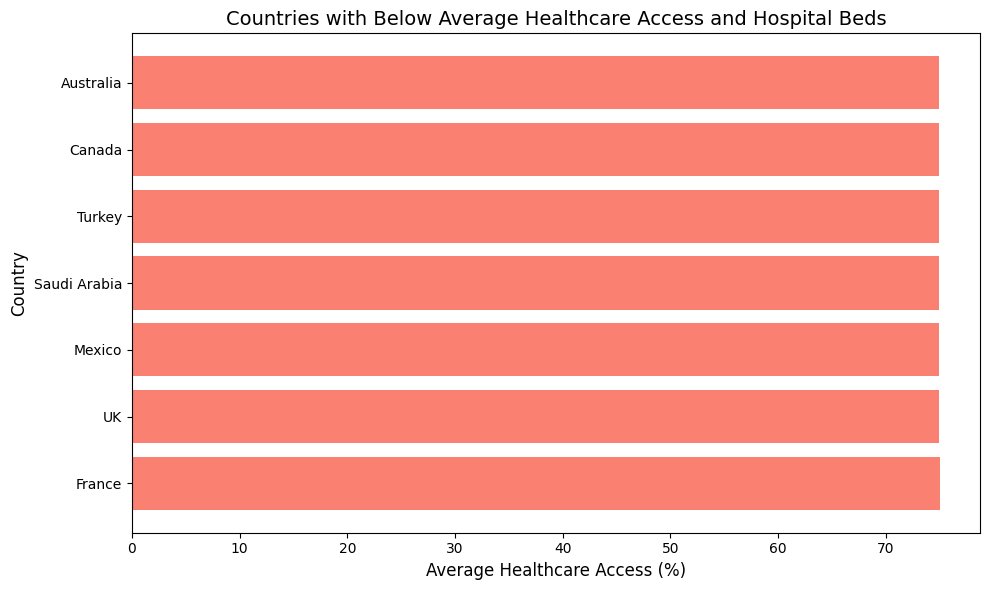

In [51]:
# What countries have the lowest access to healthcare?


from tabulate import tabulate

# Query to calculate average healthcare access and hospital beds, and filter below average
query_below_average = """
SELECT
    Country,
    AVG(HealthcareAccess) AS AvgHealthcareAccess,
    AVG(HospitalBedsPer1000) AS AvgHospitalBeds
FROM HealthStatistics
GROUP BY Country
HAVING 
    AVG(HealthcareAccess) < (SELECT AVG(HealthcareAccess) FROM HealthStatistics)
    AND AVG(HospitalBedsPer1000) < (SELECT AVG(HospitalBedsPer1000) FROM HealthStatistics)
ORDER BY AvgHealthcareAccess ASC;
"""

# Execute the query and load the data into a DataFrame (assuming connection is established)
df_below_average = pd.read_sql(query_below_average, connection)

# Display the result
print("Countries with Healthcare Access and Hospital Beds Below Average:")
print(tabulate(df_below_average, headers='keys', tablefmt='grid'))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(df_below_average['Country'], df_below_average['AvgHealthcareAccess'], color='salmon')
plt.xlabel('Average Healthcare Access (%)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Countries with Below Average Healthcare Access and Hospital Beds', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


C:\Users\dbigman\AppData\Local\Temp\ipykernel_14180\3232801228.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_highest_burden = pd.read_sql(query_highest_burden, connection)


Countries with the Highest Disease Burden:
        Country  TotalDiseaseBurden
0        Russia         125970949.0
1  South Africa         125868947.0
2        Mexico         125412035.0
3   South Korea         125266003.0
4           USA         125246167.0
5            UK         125244689.0
6       Germany         125204430.0
7        France         125203904.0
8         China         125112861.0
9        Canada         125051388.0


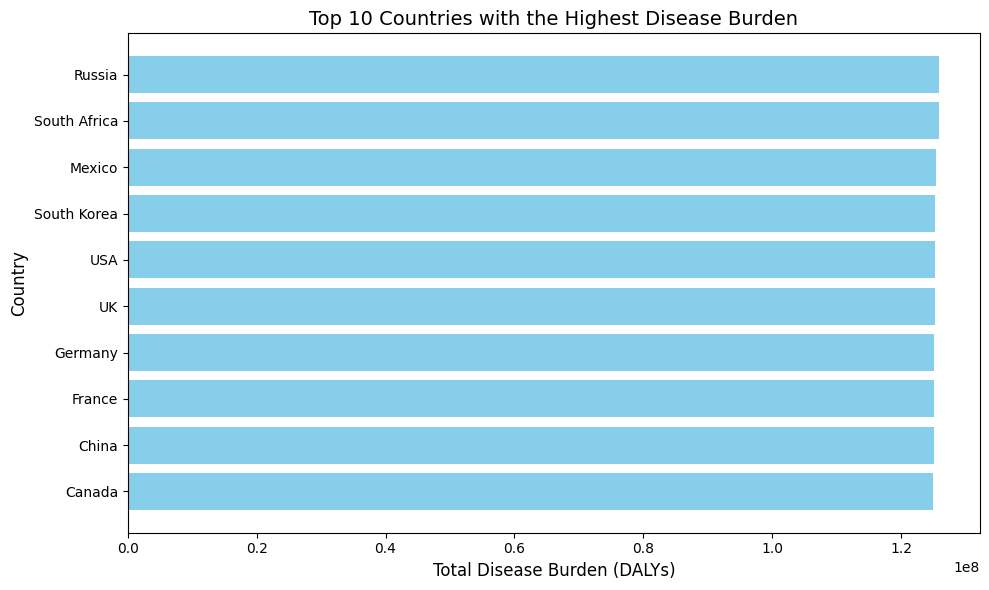

In [ ]:
# What countries have the highest disease burden?


# Query to calculate the disease burden (e.g., using DALYs) and find countries with the highest burden
query_highest_burden = """
SELECT
    Country,
    SUM(DALYs) AS TotalDiseaseBurden
FROM HealthStatistics
GROUP BY Country
ORDER BY TotalDiseaseBurden DESC
LIMIT 10;
"""

# Execute the query and load the data into a DataFrame (assuming connection is established)
df_highest_burden = pd.read_sql(query_highest_burden, connection)

# Display the result
print("Countries with the Highest Disease Burden:")
print(df_highest_burden)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(df_highest_burden['Country'], df_highest_burden['TotalDiseaseBurden'], color='skyblue')
plt.xlabel('Total Disease Burden (DALYs)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Top 10 Countries with the Highest Disease Burden', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()
